In [188]:
from utils import *

In [202]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = X.reshape(*X.shape[:2],-1)
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1])
        pos_out = out**2
        
        return pos_out

### Defining hyperparams

In [203]:
# Defining hyperparams
NUM_SEQUENCE = 91
NUM_FEATURES = 10*26
NUM_LAYERS = 3
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64
INPUT_SIZE = NUM_FEATURES
L_RATE = 0.01
num_epoches = 10000
slc = (0, -1, 0, 15)

### Loading already trained model

In [204]:
# Creating model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
model.load_state_dict(torch.load('./models/positive_model.pth'))
model.to(DEVICE);
model.train();

### Defining Reward function

In [205]:
def Reward(outputs, price):
    reward = outputs * price
    return reward.mean()

### Loading data

In [206]:
X_val = torch.split(torch.load("./data/selected_qids.pt").to(torch.float32), 1)

### Freezing params of the model

In [207]:
for param in model.parameters():
    param.requires_grad = False

# Using torch Autograd

In [208]:
history_price = np.zeros((len(sample_data), num_epoches))
history_book = np.zeros((len(sample_data), num_epoches))
history_reward = np.zeros((len(sample_data), num_epoches))

for idx, sample in enumerate(X_val):
    for epoch in range(num_epoches):

        sample.requires_grad = True

        outputs = model(sample.to(DEVICE)).squeeze()

        # Compute the Reward and its gradients
        reward = Reward(outputs.cpu(), sample[slc])
        reward.backward()

        dy_dprice = sample.grad[slc]
        sample.grad = None
        sample.requires_grad = False

        # Step to update Price
        sample[slc] += (L_RATE * dy_dprice)
        history_price[idx][epoch] = sample[slc].clone().detach().cpu().numpy()
        history_book[idx][epoch] = outputs.clone().detach().cpu().numpy()
        history_reward[idx][epoch] = reward.clone().detach().cpu().numpy()

### Visualization of results

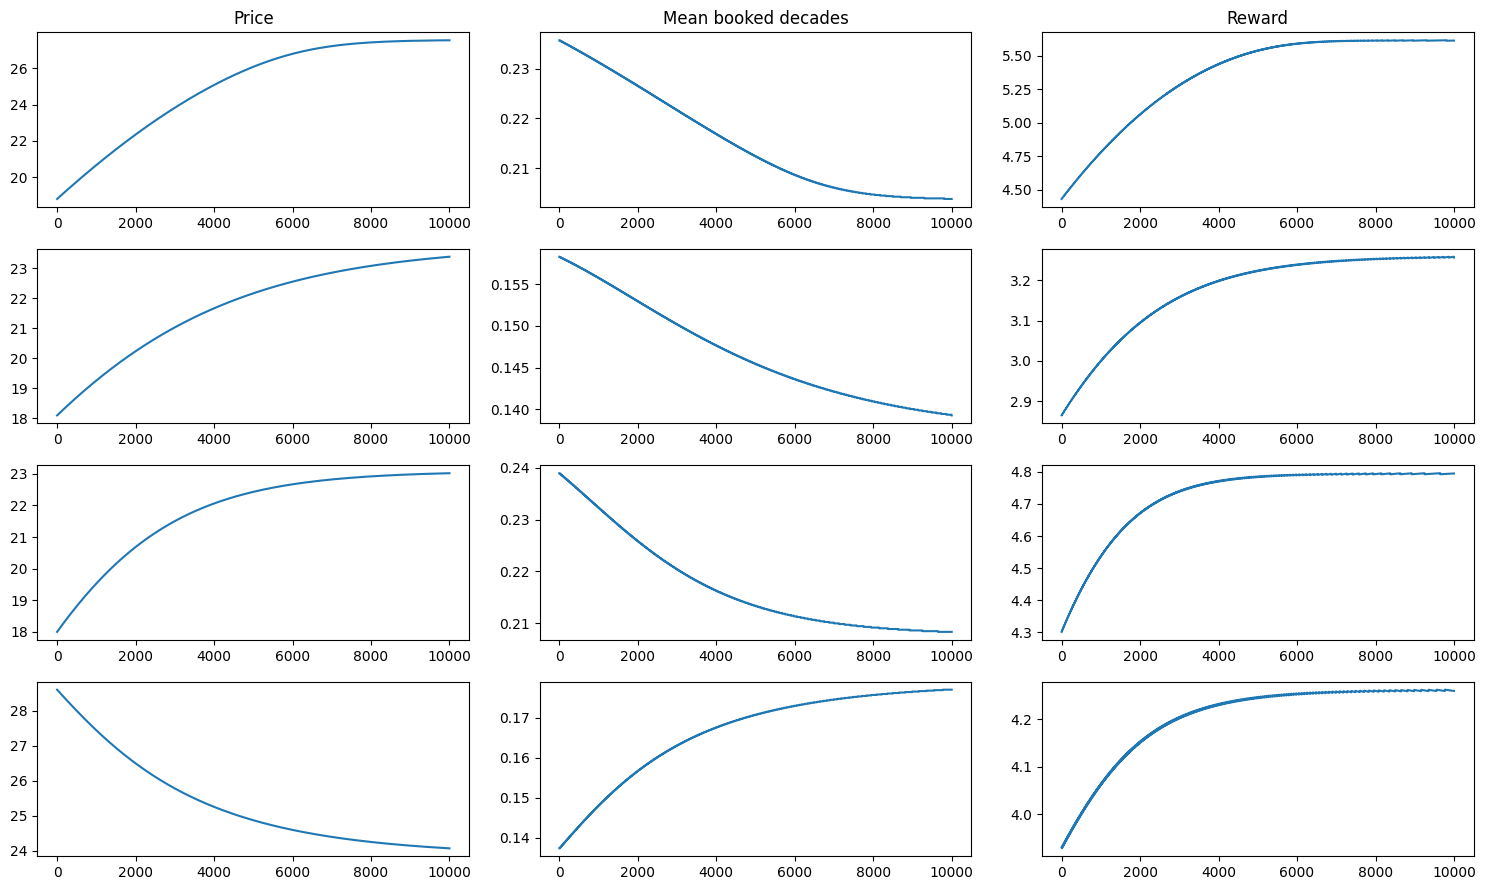

In [209]:
fig, ax = plt.subplots(4, 3, figsize=(15, 9))

for idx, _ in enumerate(sample_data):
    ax[idx, 0].plot(history_price[idx])
    ax[idx, 1].plot(history_book[idx])
    ax[idx, 2].plot(history_reward[idx])

for ax, col in zip(ax[0], ["Price", "Mean booked decades", "Reward"]):
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Visualization of results: time vs others

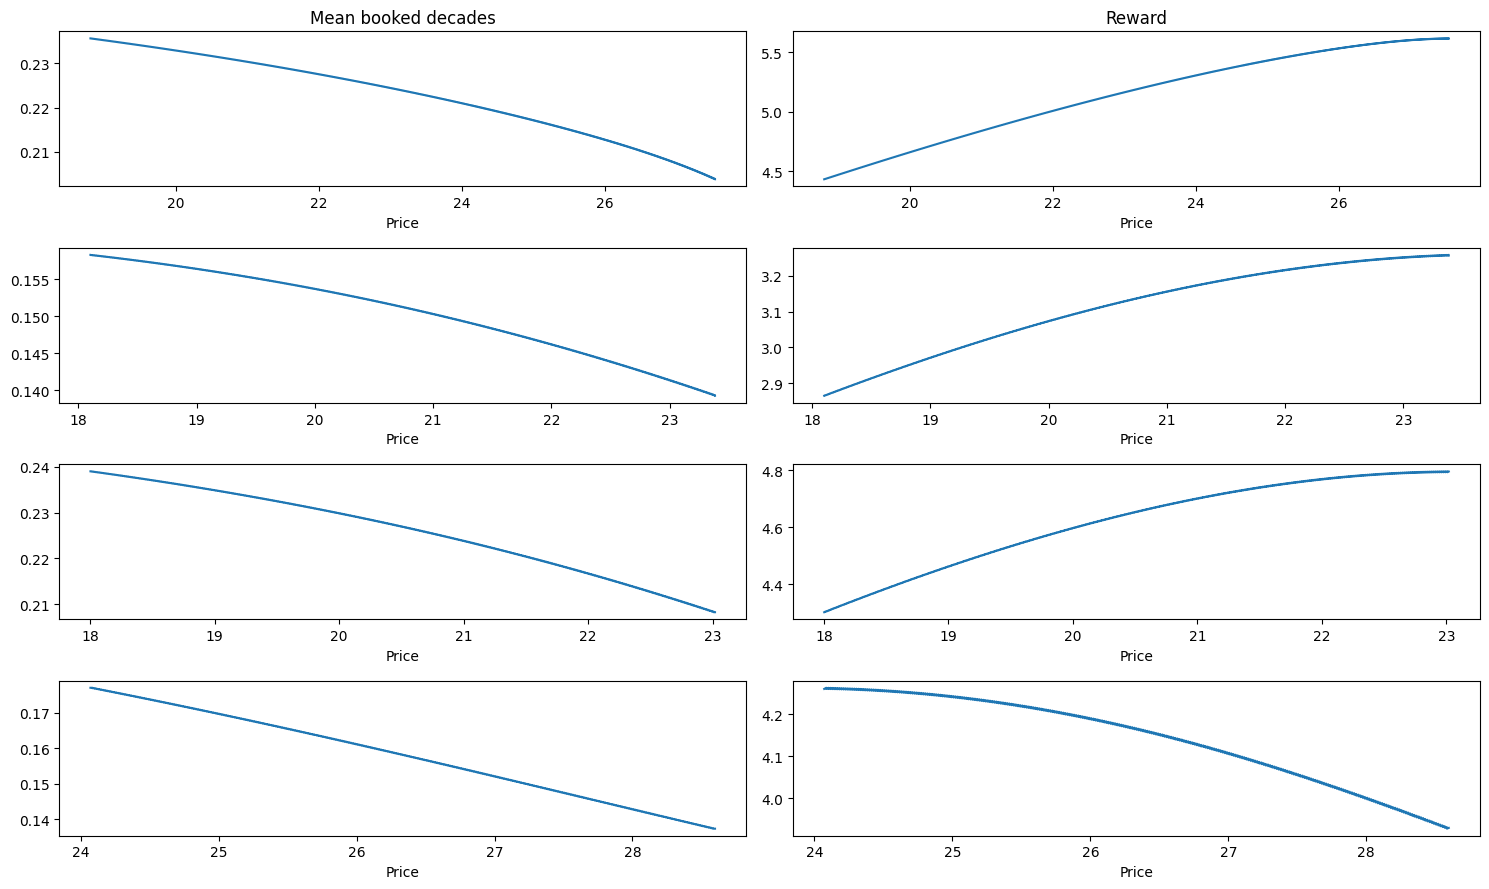

In [210]:
fig, ax = plt.subplots(4, 2, figsize=(15, 9))

for idx, _ in enumerate(sample_data):
    ax[idx, 0].plot(history_price[idx], history_book[idx])
    ax[idx, 1].plot(history_price[idx], history_reward[idx])

for ax_, col in zip(ax[0], ["Mean booked decades", "Reward"]):
    ax_.set_title(col)

for i in range(4):
    ax[i, 0].set_xlabel(f"Price")
    ax[i, 1].set_xlabel(f"Price")
    

plt.tight_layout()
plt.show()

# Optimizing using Scipy

In [211]:
model = model.cpu()

In [212]:
X_val = torch.split(torch.load("./data/selected_qids.pt").to(torch.float32), 1)

In [213]:
from scipy.optimize import minimize

m_ = []
r_ = []
p_ = []

def f(p):
    global m_
    global r_
    global p_

    
    sample[slc] = torch.tensor(p)
    m = model(sample).item()
    m_.append(m)
    
    r_.append(p * m)
    p_.append(p)
    
    return -(p * m)

def custom_callback(arg):
    p_.append(arg[0])

In [214]:
slc = (0, -1, 0, 15)

P = []
M = []
R = []

for idx, sample in enumerate(X_val):
    x = sample[slc]
    result = minimize(f, x, method='TNC', 
                      options={"maxiter": 50, "disp": False},
                      tol=1e-3)
    
    P.append(torch.tensor(p_))
    M.append(torch.tensor(m_))
    R.append(torch.tensor(r_))
    
    m_ = []
    r_ = []
    p_ = []

/tmp/ipykernel_2633710/3672444919.py:9: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(f, x, method='TNC',


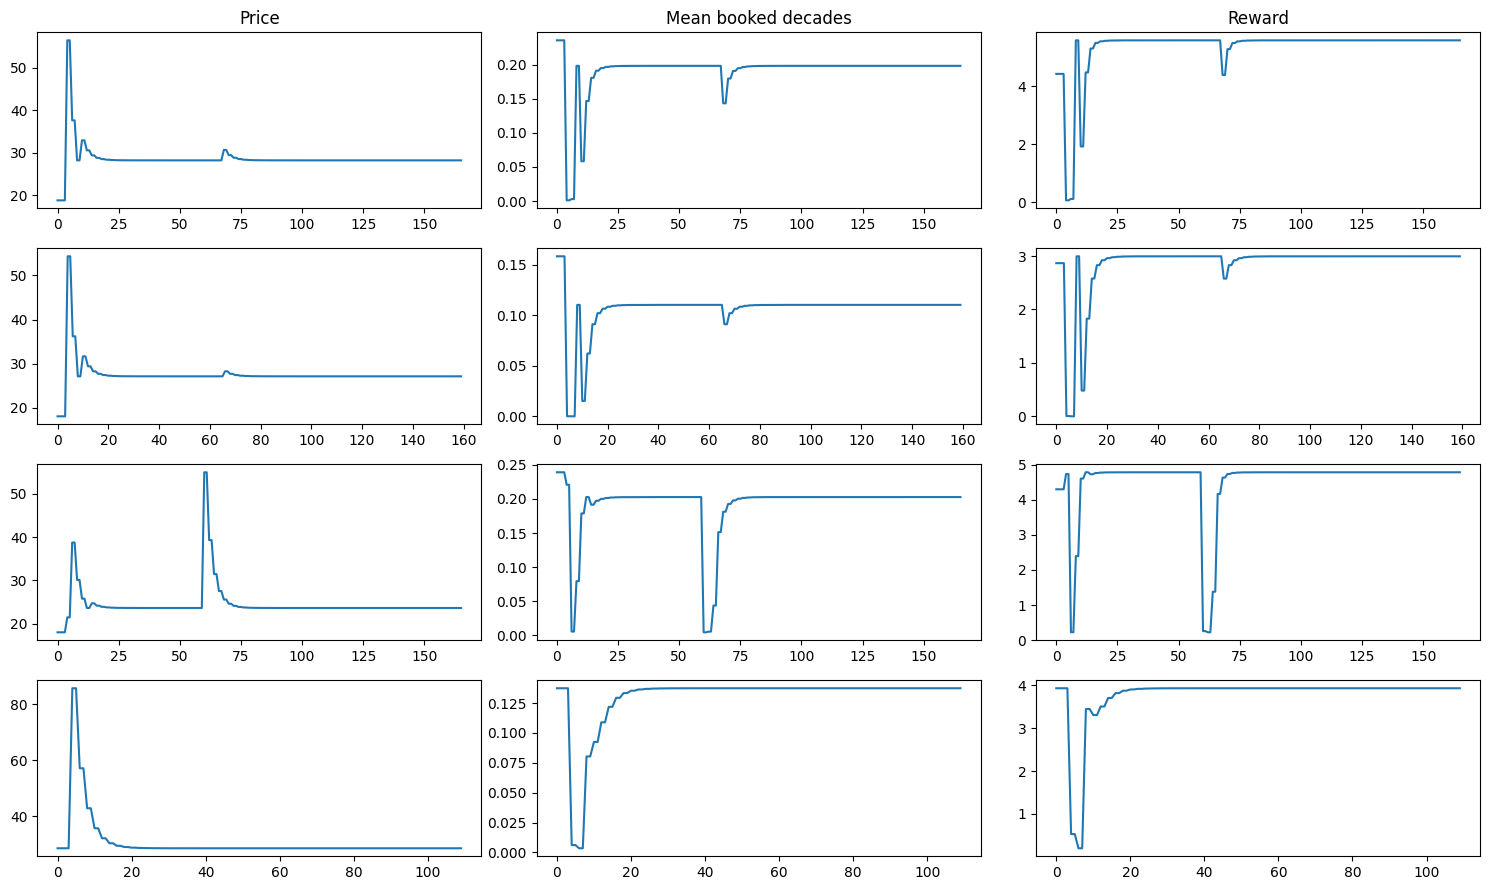

In [215]:
fig, ax = plt.subplots(len(sample_data), 3, figsize=(15, 9))

for idx, _ in enumerate(sample_data):
    ax[idx, 0].plot(P[idx])
    ax[idx, 1].plot(M[idx])
    ax[idx, 2].plot(R[idx])

for ax, col in zip(ax[0], ["Price", "Mean booked decades", "Reward"]):
    ax.set_title(col)
plt.tight_layout()
plt.show()